Copyright 2021 The TensorFlow Similarity Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [5]:
from collections import defaultdict
import os

# from matplotlib import pyplot as plt
# from mpl_toolkits import axes_grid1
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

In [7]:
# install TF similarity if needed
try:
    import tensorflow_similarity as tfsim  # main package
except:
    !pip install tensorflow_similarity
    import tensorflow_similarity as tfsim

In [10]:
from tensorflow_similarity.samplers import SingleShotMemorySampler
from tensorflow_similarity.augmenters import SimCLRAugmenter
from tensorflow_similarity.models import ContrastiveModel
from tensorflow_similarity.losses import SimSiamLoss
from tensorflow_similarity.training_metrics import encoder_std  ## siam siam metric
from tensorflow_similarity.visualization import visualize_views

In [9]:
tfsim.utils.tf_cap_memory() # Avoid GPU memory blow up

2021-10-22 01:16:43.927439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 01:16:43.936763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 01:16:43.937521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [14]:
def plot_25(x, y):
    """Plot the first 25 images."""
    num_cols = num_rows = 5
    fig = plt.figure(figsize=(6.0, 6.0))
    grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

    for ax, im, label in zip(grid, x, y):
        ax.imshow(im)
        ax.axis("off")

# dataset

## loading

In [11]:
(x_train, y_raw_train), (x_test, y_raw_test) = keras.datasets.cifar100.load_data()
print("x_train", x_train.shape, "x_test", x_test.shape)
y_train = keras.utils.to_categorical(y_raw_train, 100)
y_test = keras.utils.to_categorical(y_raw_test, 100)
print("y_train", y_train.shape, "y_test", y_test.shape)

169017344/169001437 [==============================] - 2s 0us/step
x_train (50000, 32, 32, 3) x_test (10000, 32, 32, 3)
y_train (50000, 100) y_test (10000, 100)


In [12]:
IMG_SIZE = 32
PRE_TRAIN_IMGS = 128
TRAIN_BATCH_SIZE = 64
STEPS_PER_EPOCH = 5000

In [13]:
train_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=True)
#     #test_augmenter = SimCLRAugmenter(IMG_SIZE,IMG_SIZE, is_training=False)
sampler = SingleShotMemorySampler(x_train, examples_per_batch=PRE_TRAIN_IMGS, steps_per_epoch=STEPS_PER_EPOCH, augmenter=train_augmenter, num_augmentations_per_example=2)


The initial batch size is 128 (128 classes * 1 examples per class) with 2 augmenters


2021-10-22 02:54:31.439339: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-22 02:54:31.440218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 02:54:31.440894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 02:54:31.441478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

2021-10-22 02:55:45.094560: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


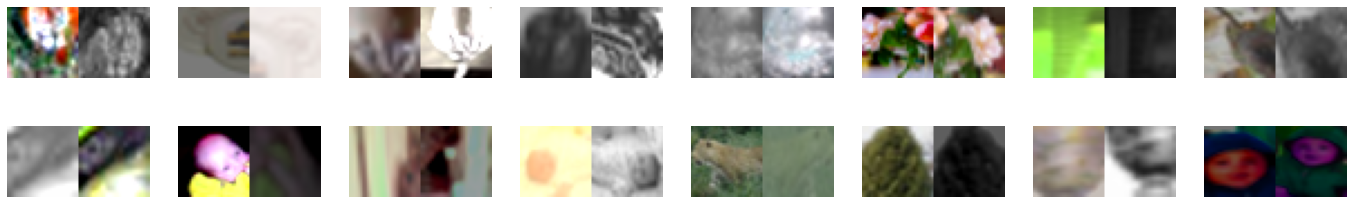

In [15]:
views = sampler.generate_batch(0)

visualize_views(views=views, num_imgs=16, views_per_col=8)

# Models

## backbone 

In [16]:
def get_encoder(IMG_SIZE, dim=2048, activation='relu', trainable=True):
    base_model = tf.keras.applications.ResNet50V2(include_top=False,
        weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = trainable

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    # no rescaling as efficientnet do it for you
    x = base_model(inputs, training=True)
 
    # projection mlp
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dim)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)  # 3
    x = layers.Dense(dim)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)  # 6
    o = layers.Dense(dim)(x)
    backbone = Model(inputs, o, name='encoder')
    return backbone
encoder = get_encoder(IMG_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 1, 1, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196

## projector model

In [17]:
def get_projector(dim, hidden_dim, activation='relu'):
    inputs = layers.Input(shape=(dim,))
    x = layers.Dense(dim)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x) 
    x = layers.Dense(dim)(x)
    projector = Model(inputs, x, name="projector")
    return projector

projector = get_projector(2048, 512)
projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0 

# Loss

In [18]:
loss = SimSiamLoss
metrics = [[encoder_std], []]

In [ ]:
PRE_TRAIN_EPOCHS = 1
contrastive_model = ContrastiveModel(encoder_model=encoder, 
                         projector_model=projector, 
                         swap_representation=True)
# use sgd as optimizer with constant loss as recommende in the paper.
contrastive_model.compile('sgd', loss=loss, metrics=metrics)
contrastive_history = contrastive_model.fit(sampler, epochs=PRE_TRAIN_EPOCHS)

2021-10-22 02:57:01.773288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 160/5000 [..............................] - ETA: 21:51 - loss: 2.1587 - output_1_encoder_std: 0.0221

# Evaluation

In [151]:
TEST_EPOCHS = 20
LR = 0.01
from tensorflow_similarity.samplers import select_examples
# allows to use a fraction of the dataset via select_sample
x_restricted, y_restricted = select_examples(x_train, y_raw_train, num_examples_per_class=100)
y_restricted = keras.utils.to_categorical(y_restricted, 100)

gather examples: 100%|██████████| 10000/10000 [00:00<00:00, 1666721.24it/s]


In [57]:
def get_model(IMG_SIZE, decoder, LR, training):
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = decoder(inputs, training=training)
    o = layers.Dense(256, activation='relu')(x)
    o = layers.BatchNormalization()(o)
    o = layers.Dense(100, activation='softmax')(o)
    model = Model(inputs, o, name='no_pretrain')
    optim = SGD(LR)
    model.compile(optim, loss='categorical_crossentropy', metrics=['acc'])
    return model

# No pretrain

In [58]:
reg_model = get_model(IMG_SIZE, get_encoder(IMG_SIZE), LR, training=True)
reg_history = reg_model.fit(x_restricted, y_restricted, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
157/157 [==============================] - 10s 47ms/step - loss: 4.6567 - acc: 0.0378 - val_loss: 4.4357 - val_acc: 0.0468
Epoch 2/20
157/157 [==============================] - 7s 43ms/step - loss: 4.1321 - acc: 0.0853 - val_loss: 4.2525 - val_acc: 0.0652
Epoch 3/20
157/157 [==============================] - 8s 53ms/step - loss: 3.8815 - acc: 0.1147 - val_loss: 4.1231 - val_acc: 0.0809
Epoch 4/20
157/157 [==============================] - 8s 53ms/step - loss: 3.6685 - acc: 0.1523 - val_loss: 4.1177 - val_acc: 0.0866
Epoch 5/20
157/157 [==============================] - 8s 52ms/step - loss: 3.4997 - acc: 0.1870 - val_loss: 4.0935 - val_acc: 0.0983
Epoch 6/20
157/157 [==============================] - 8s 52ms/step - loss: 3.3144 - acc: 0.2159 - val_loss: 4.0574 - val_acc: 0.1087
Epoch 7/20
157/157 [==============================] - 8s 49ms/step - loss: 3.1241 - acc: 0.2607 - val_loss: 4.0396 - val_acc: 0.1113
Epoch 8/20
157/157 [==============================] - 6s 38ms/step -

In [15]:
# pretrained with SiamSiam


In [155]:
contrastive_model.projector.summary()

Model: "projector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
dense_100 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_79 (Batc (None, 2048)              8192      
_________________________________________________________________
activation_12 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_101 (Dense)            (None, 512)               1049088   
_________________________________________________________________
batch_normalization_80 (Batc (None, 512)               2048      
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0 

In [157]:
LR = 0.001
encoder = contrastive_model.get_encoder()
encoder.trainable = False
projection_layer = contrastive_model.projector.get_layer(index=1)
projection_layer.trainable = False

inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
x = encoder(inputs)
x = projection_layer(x)
o = x
# o = layers.BatchNormalization()(o)
# o = layers.Dense(256, activation='relu')(x)
o = layers.BatchNormalization()(o)
o = layers.Dense(100, activation='softmax')(o)
model2 = Model(inputs, o, name='no_pretrain')
optim = SGD(LR)
model2.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
model2.summary()

Model: "no_pretrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_80 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 2048)              36170240  
_________________________________________________________________
dense_100 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_83 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_105 (Dense)            (None, 100)               204900    
Total params: 40,579,684
Trainable params: 208,996
Non-trainable params: 40,370,688
_________________________________________________________________


In [158]:
TEST_EPOCHS = 20

# encoder = contrastive_model.get_encoder()
# encoder.trainable = False
# pre_model = get_model(IMG_SIZE, enc2, 0.001, training=False)

model2.compile('adam', loss='categorical_crossentropy', metrics=['acc'])
pre_history = model2.fit(x_restricted, y_restricted, batch_size=TRAIN_BATCH_SIZE, epochs=TEST_EPOCHS, validation_data=(x_test, y_test))

Epoch 1/20
157/157 [==============================] - 10s 44ms/step - loss: 4.6467 - acc: 0.0665 - val_loss: 5.0570 - val_acc: 0.0684
Epoch 2/20
157/157 [==============================] - 8s 48ms/step - loss: 3.8168 - acc: 0.1711 - val_loss: 4.6125 - val_acc: 0.0869
Epoch 3/20
157/157 [==============================] - 5s 33ms/step - loss: 3.4318 - acc: 0.2243 - val_loss: 4.6105 - val_acc: 0.0876
Epoch 4/20
157/157 [==============================] - 5s 34ms/step - loss: 3.1772 - acc: 0.2705 - val_loss: 4.7365 - val_acc: 0.0822
Epoch 5/20
157/157 [==============================] - 5s 34ms/step - loss: 2.9608 - acc: 0.3142 - val_loss: 4.7554 - val_acc: 0.0850
Epoch 6/20
157/157 [==============================] - 7s 46ms/step - loss: 2.8112 - acc: 0.3407 - val_loss: 4.8093 - val_acc: 0.0846
Epoch 7/20
157/157 [==============================] - 9s 58ms/step - loss: 2.6634 - acc: 0.3687 - val_loss: 4.9145 - val_acc: 0.0815
Epoch 8/20
157/157 [==============================] - 6s 37ms/step -

KeyboardInterrupt: 

In [17]:
print('no pretrain', reg_model.evaluate(x_test, y_test))
print('pretrained', model2.evaluate(x_test, y_test))

313/313 [==============================] - 4s 11ms/step - loss: 5.8034 - acc: 0.0082
no pretrain [5.803400039672852, 0.008200000040233135]
313/313 [==============================] - 3s 9ms/step - loss: 4.6630 - acc: 0.0101
pretrained [4.6629767417907715, 0.010099999606609344]
